In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import database
import vertical_integral
import pylab as PP
import xarray as xr

/global/homes/t/taobrien/.conda/envs/climate-notebook/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
cmip6_database = database.load()

In [3]:
""" Get a list of sample files for each model """
# search for historical watervapor data on native 3D levels
search_criteria = dict(simulation = "historical",
                       variable = "hus", 
                       group = "6hrLev"
                      )
cmip6_subset = database.select_by_dict(cmip6_database, **search_criteria)

# generate a combination of model, ensemble pairs, where
# the ensemble is the first ensemble member found for each model
sample_model_ensemble_matches = cmip6_subset.groupby(by = ["model"]).ensemble.unique().apply(lambda x: x[0])

unique_files = {}
for model, ensemble in sample_model_ensemble_matches.items():
    # select a particular model/ensemble
    this_search = dict(search_criteria)
    this_search['model'] = model
    this_search['ensemble'] = ensemble
    
    # search for the matching file
    selected_run = database.select_by_dict(cmip6_subset, **this_search)
    
    # get its path
    unique_files[model] = database.reconstruct_path(selected_run).iloc[0]
    
xr_files = {}
for model, ufile in unique_files.items(): 
    xr_files[model] = xr.open_dataset(ufile,
                                      decode_coords = False,
                                      decode_times = False,
                                      drop_variables = ['time'],
                                      chunks = {})

/global/homes/t/taobrien/.conda/envs/climate-notebook/lib/python3.6/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'hus' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


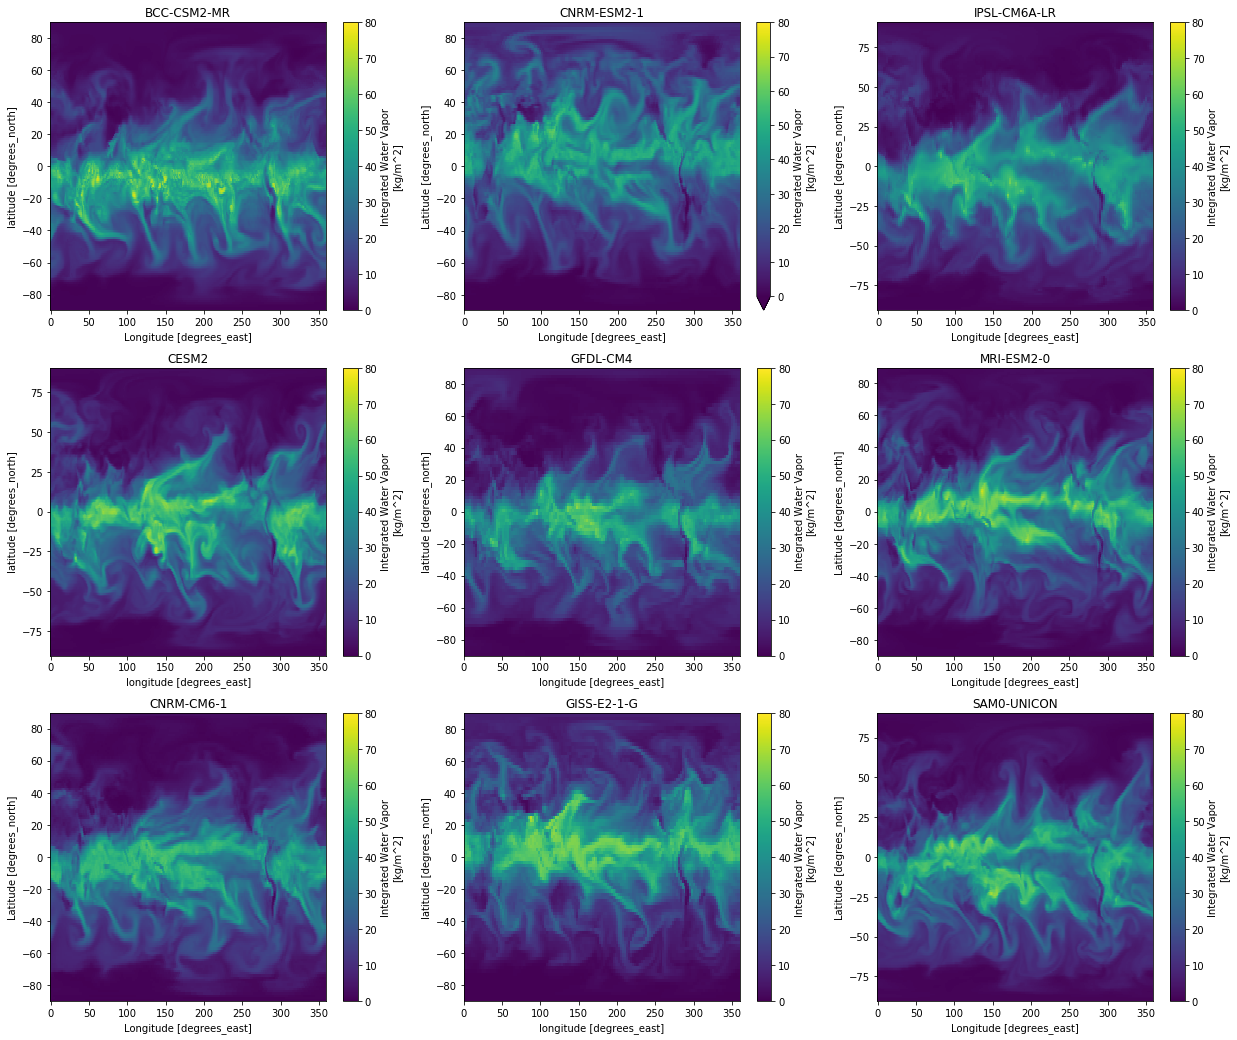

In [5]:
fig, axs = PP.subplots(3,3,figsize = (21,18))

i = 0
j = 0
for model in xr_files:
    xrd = xr_files[model].isel(time = 0).load()
    
    iwv_ds = vertical_integral.integrate(xrd)
    
    iwv = iwv_ds['hus']
    iwv.attrs['long_name'] = "Integrated Water Vapor"
    iwv.attrs['units'] = "kg/m^2"
        
    ax = axs[i][j]
    iwv.plot(vmin = 0, vmax = 80, ax = ax)
    ax.set_title(model)
    
    i += 1
    if i >= 3:
        i = 0
        j += 1
    
PP.savefig('iwv_snapshots.png')
PP.show()
    #